In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from dotmap import DotMap

In [188]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
# NORM_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"
sys.path.insert(0, PROJECT_PATH)

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data

In [190]:
with h5py.File(NORM_PATH, 'r') as f:
    flux = f['flux'][()]
#     mask = f['flux_idx'][()]
    wave = f['wave'][()]
#     eigv = f['flux_eigv'][()]

In [206]:
dfpara0 = pd.read_csv("/home/swei20/AE/data/para.csv")

In [194]:
flux.shape

(116614, 15404)

In [207]:
dfpara = pd.DataFrame(data = dfpara0[["FeH", "Teff", "Logg","C_M","O_M"]].values, columns=["F","T","L","C","O"])

In [200]:
with h5py.File(NORM_PATH, 'a') as f:
    f.create_dataset("para", data=para, shape=para.shape)

In [ ]:
# dfpara = pd.DataFrame(data=np.transpose(np.where(mask)), columns=["F","T","L","C","O"])

In [205]:
para

,F,T,L,C,O
0,-2.50,3500.0,0.0,-0.50,-0.25
1,-2.50,3500.0,0.0,-0.50,0.00
2,-2.50,3500.0,0.0,-0.50,0.25
3,-2.50,3500.0,0.0,-0.50,0.50
4,-2.50,3500.0,0.0,-0.25,-0.25
...,...,...,...,...,...
116609,0.75,30000.0,5.0,0.25,0.50
116610,0.75,30000.0,5.0,0.50,-0.25
116611,0.75,30000.0,5.0,0.50,0.00
116612,0.75,30000.0,5.0,0.50,0.25


In [229]:
id_test = dfpara[(dfpara["T"] >=6500) & (dfpara["C"] ==0.0)&  (dfpara["O"] ==0.0) ].index

In [230]:
para_HT = dfpara.iloc[id_test]
para_HT

,F,T,L,C,O
2514,-2.50,6500.0,1.0,0.0,0.0
2534,-2.50,6500.0,1.5,0.0,0.0
2554,-2.50,6500.0,2.0,0.0,0.0
2574,-2.50,6500.0,2.5,0.0,0.0
2594,-2.50,6500.0,3.0,0.0,0.0
...,...,...,...,...,...
116526,0.75,30000.0,3.0,0.0,0.0
116543,0.75,30000.0,3.5,0.0,0.0
116563,0.75,30000.0,4.0,0.0,0.0
116583,0.75,30000.0,4.5,0.0,0.0


In [232]:
flux_HT = flux[para_HT.index]

In [233]:
flux_Hw, wave_Hw = get_flux_in_Wrange(flux_HT, wave, [8000, 13000])

In [234]:
flux_Hw.shape

(4526, 4855)

In [244]:
from lv.rpca import RPCA

In [251]:
flux_Hw0 = flux_Hw - np.mean(flux_Hw, axis=0)

In [254]:
flux.shape

(116614, 15404)

In [255]:
flux_m = flux - np.mean(flux, axis=0)

In [257]:
np.linalg.norm(flux_Hw0, ord=2)

91.20171285773355

In [256]:
np.abs(flux_m).max()

9.816573223866719

In [ ]:
p1=RPCA(flux_Hw0, wave_Hw, la=10.0, n_iter=100, ratio=0.0005)
p1.pcp()

=====Initializing RPCA ======

iter	       res	     eps r	        dz	     eps U	      loss

=====Starting RPCA=====
|EP1_S_0 L_21

   1	   27.6553	    1.5612	    7.4932	    0.8817	     38.99
|EP2_S_309 L_31|EP3_S_339 L_36|EP4_S_350 L_46|EP5_S_345 L_56|EP6_S_294 L_60|EP7_S_85 L_58|EP8_S_477 L_58|EP9_S_100 L_50|EP10_S_191 L_50

  10	   43.3748	    2.1799	    2.7697	    0.8768	     67.37
|EP11_S_224 L_53|EP12_S_243 L_59|EP13_S_232 L_64|EP14_S_115 L_64|EP15_S_276 L_63|EP16_S_29 L_62|EP17_S_96 L_57|EP18_S_132 L_57|EP19_S_150 L_63|EP20_S_160 L_67

  20	    9.6249	    1.9096	    1.8191	    0.8498	     29.23
|EP21_S_138 L_70|EP22_S_26 L_70|EP23_S_102 L_71|EP24_S_34 L_66|EP25_S_66 L_63|EP26_S_86 L_64|EP27_S_98 L_69|EP28_S_93 L_72|EP29_S_43 L_72|EP30_S_36 L_73

  30	   19.4659	    1.8658	    0.4659	    0.8243	     12.73
|EP31_S_15 L_72|EP32_S_35 L_68|EP33_S_45 L_69|EP34_S_53 L_72|EP35_S_57 L_75|EP36_S_47 L_75|EP37_S_13 L_75|EP38_S_12 L_76|EP39_S_20 L_75|EP40_S_29 L_72

  40	   13.5845	    2.0151

In [ ]:
p2=RPCA(flux_Hw0, wave_Hw, la=5.0, n_iter=100, ratio=0.0005)
p2.pcp()

In [ ]:
p3=RPCA(flux_Hw0, wave_Hw, la=1.0, n_iter=100, ratio=0.0005)
p3.pcp()

In [ ]:
p4=RPCA(flux_Hw0, wave_Hw, la=10.0, n_iter=100, ratio=0.005)
p4.pcp()

L_29|EP37_S_17 L_29|EP38_S_20 L_29|EP39_S_23 L_30|EP40_S_25 

In [63]:
from umap import UMAP

In [71]:
u  = UMAP(n_components=3).fit_transform(fluxaa)

In [74]:
u.shape

(1068, 3)

In [72]:
dfpp = dfpara.iloc[idxx]

In [76]:
for i in range(3):
    dfpp[f"u{i}"] = u[:,  i]

<ipython-input-76-fb6fe86d7154>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpp[f"u{i}"] = u[:,  i]


In [77]:
import  seaborn  as sns

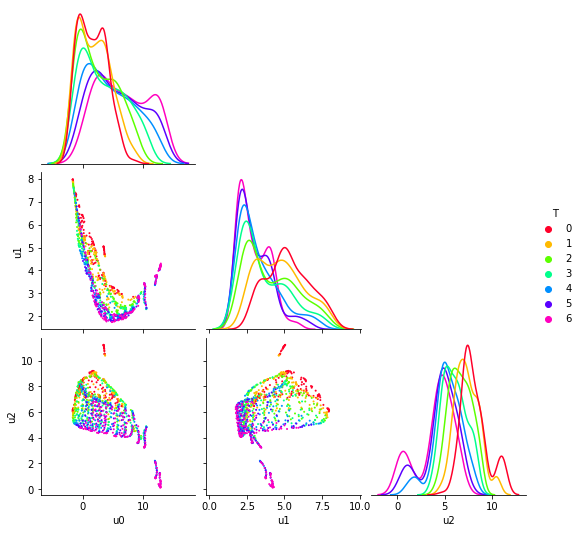

In [82]:
sns.pairplot(
            dfpp,
            x_vars=[f"u{i}" for i in range(3)],
            y_vars=[f"u{i}" for i in range(3)],
            hue="T",
            plot_kws=dict(marker="o", s=4, edgecolor="none"),
            diag_kws=dict(fill=False),
            palette="gist_rainbow",
            corner=True
        )

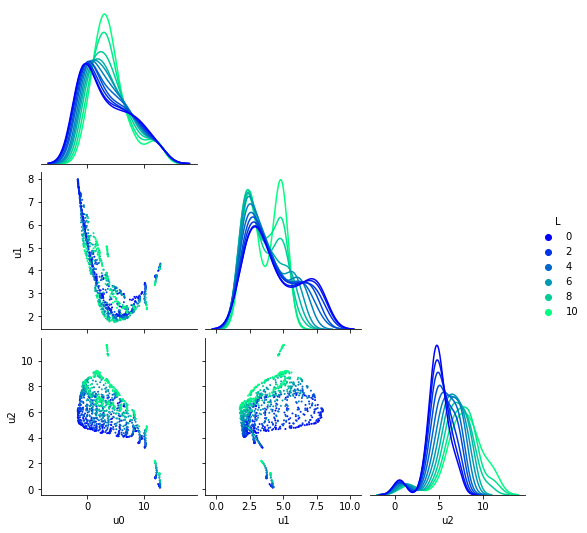

In [83]:
sns.pairplot(
            dfpp,
            x_vars=[f"u{i}" for i in range(3)],
            y_vars=[f"u{i}" for i in range(3)],
            hue="L",
            plot_kws=dict(marker="o", s=4, edgecolor="none"),
            diag_kws=dict(fill=False),
            palette="winter",
            corner=True
        )

In [54]:
from lv.rpca import RPCA
p=RPCA(fluxaa)
p.pcp()

=====Initializing RPCA ======


  0%|          | 0/100 [00:00<?, ?it/s]


iter	       res	     eps r	        dz	     eps U	      loss


  1%|          | 1/100 [00:10<17:11, 10.42s/it]

   1	  576.9295	    9.3612	  906.4700	    9.1100	 129324.50


 10%|█         | 10/100 [01:56<18:00, 12.01s/it]

  10	  176.0935	   12.1168	   96.0345	    8.5966	 400049.40


 20%|██        | 20/100 [04:13<19:52, 14.91s/it]

  20	   28.1348	   13.3625	   52.7014	    8.0026	 463614.19


 30%|███       | 30/100 [06:26<14:09, 12.13s/it]

  30	   21.6851	   13.6695	   19.8796	    7.4646	 458877.50


 36%|███▌      | 36/100 [07:19<13:01, 12.21s/it]

t: 439.61


In [108]:
meann=np.mean(fluxaa, axis=0)

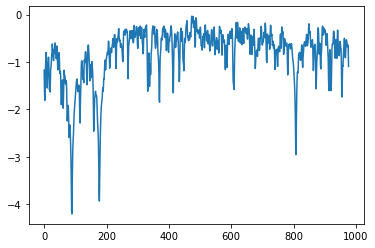

In [111]:
plt.plot(meann)

In [110]:
fluxaa.shape

(1068, 977)

In [109]:
meann.shape

(977,)

In [103]:
fluxaaa = fluxaa -  np.mean(fluxaa, axis=0)

In [185]:
# p10=RPCA(fluxaaa, la=10, ratio =0.005, n_iter=50)
# p10.pcp()

In [242]:
np.linalg.norm(flux_Hw, ord=2)

253.38692492414103

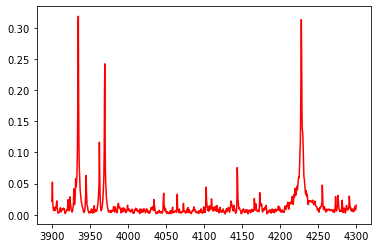

In [243]:
plt.plot(waveaa, np.mean(np.abs(p10.S), axis=0),c='r')

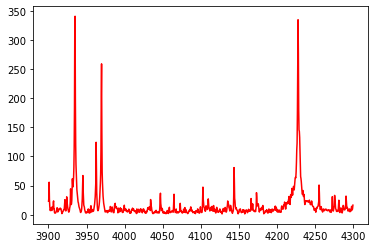

In [186]:
plt.plot(waveaa, np.sum(np.abs(p10.S), axis=0),c='r')

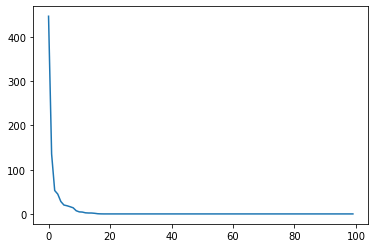

In [187]:
s  = np.linalg.svd(p.L,  compute_uv=0)
plt.plot(s[:100])

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
# plt.plot(waveaa, np.sum(np.abs(p10.S), axis=0),c='r')

In [116]:
p=RPCA(fluxaaa, ratio =0.005)
p.pcp()

=====Initializing RPCA ======


  0%|          | 0/100 [00:00<?, ?it/s]


iter	       res	     eps r	        dz	     eps U	      loss
(17,)


  1%|          | 1/100 [00:04<07:54,  4.79s/it]

   1	   61.2705	    3.2342	  305.7263	    3.1655	  10204.01
(22,)


  2%|▏         | 2/100 [00:08<06:41,  4.09s/it]

(22,)


  3%|▎         | 3/100 [00:12<06:31,  4.03s/it]

(19,)


  4%|▍         | 4/100 [00:17<06:56,  4.34s/it]

(14,)


  5%|▌         | 5/100 [00:21<07:02,  4.45s/it]

(11,)


  6%|▌         | 6/100 [00:25<06:39,  4.25s/it]

(10,)


  7%|▋         | 7/100 [00:29<06:23,  4.12s/it]

(13,)


  8%|▊         | 8/100 [00:33<06:22,  4.16s/it]

(15,)


  9%|▉         | 9/100 [00:38<06:38,  4.38s/it]

(14,)


 10%|█         | 10/100 [00:44<07:04,  4.72s/it]

  10	  156.5659	    5.4982	   36.8258	    0.6005	   8451.69
(12,)


 11%|█         | 11/100 [00:48<06:47,  4.57s/it]

(10,)


 12%|█▏        | 12/100 [00:51<06:06,  4.17s/it]

(9,)


 13%|█▎        | 13/100 [00:59<07:42,  5.32s/it]

(11,)


 14%|█▍        | 14/100 [01:06<08:24,  5.86s/it]

(13,)


 15%|█▌        | 15/100 [01:10<07:28,  5.28s/it]

(13,)


 16%|█▌        | 16/100 [01:16<07:30,  5.37s/it]

(13,)


 17%|█▋        | 17/100 [01:20<07:01,  5.07s/it]

(12,)


 18%|█▊        | 18/100 [01:24<06:31,  4.78s/it]

(11,)


 19%|█▉        | 19/100 [01:27<05:47,  4.29s/it]

(10,)


 20%|██        | 20/100 [01:30<05:05,  3.82s/it]

  20	   76.3937	    3.9684	   17.9735	    0.3638	   2509.26
(13,)


 21%|██        | 21/100 [01:32<04:22,  3.33s/it]

(14,)


 22%|██▏       | 22/100 [01:34<03:52,  2.97s/it]

(14,)


 23%|██▎       | 23/100 [01:37<03:32,  2.76s/it]

(13,)


 24%|██▍       | 24/100 [01:50<07:21,  5.81s/it]

(13,)


 25%|██▌       | 25/100 [01:52<06:01,  4.81s/it]

(12,)


 26%|██▌       | 26/100 [01:54<04:57,  4.02s/it]

(13,)


 27%|██▋       | 27/100 [01:58<04:37,  3.81s/it]

(15,)


 28%|██▊       | 28/100 [02:01<04:25,  3.69s/it]

(15,)


 29%|██▉       | 29/100 [02:04<04:09,  3.51s/it]

(15,)


 30%|███       | 30/100 [02:07<03:51,  3.30s/it]

  30	   37.5217	    4.6591	   10.0185	    0.4539	   3664.36
(15,)


 31%|███       | 31/100 [02:09<03:33,  3.09s/it]

(14,)


 32%|███▏      | 32/100 [02:13<03:38,  3.21s/it]

(14,)


 33%|███▎      | 33/100 [02:17<03:48,  3.41s/it]

(15,)


 34%|███▍      | 34/100 [02:21<03:50,  3.50s/it]

(15,)


 35%|███▌      | 35/100 [02:25<04:01,  3.72s/it]

(16,)


 36%|███▌      | 36/100 [02:28<03:42,  3.48s/it]

(15,)


 37%|███▋      | 37/100 [02:30<03:18,  3.15s/it]

(15,)


 38%|███▊      | 38/100 [02:33<03:16,  3.16s/it]

(15,)


 39%|███▉      | 39/100 [02:37<03:19,  3.27s/it]

(15,)


 40%|████      | 40/100 [02:40<03:11,  3.19s/it]

  40	   18.0591	    4.4634	    5.6334	    0.3965	   2574.91
(16,)


 41%|████      | 41/100 [02:43<03:10,  3.23s/it]

(16,)


 42%|████▏     | 42/100 [02:47<03:14,  3.35s/it]

(16,)


 43%|████▎     | 43/100 [02:51<03:24,  3.59s/it]

(16,)


 44%|████▍     | 44/100 [02:54<03:19,  3.56s/it]

(16,)


 45%|████▌     | 45/100 [02:57<03:04,  3.36s/it]

(16,)


 46%|████▌     | 46/100 [03:01<03:03,  3.40s/it]

(16,)


 47%|████▋     | 47/100 [03:04<03:04,  3.48s/it]

(16,)


 48%|████▊     | 48/100 [03:07<02:44,  3.17s/it]

(16,)


 49%|████▉     | 49/100 [03:10<02:37,  3.08s/it]

(17,)


 50%|█████     | 50/100 [03:14<02:44,  3.29s/it]

  50	    8.7706	    4.7009	    3.7540	    0.4186	   2812.28
(16,)


 51%|█████     | 51/100 [03:18<02:51,  3.50s/it]

(16,)


 52%|█████▏    | 52/100 [03:22<02:55,  3.66s/it]

(16,)


 53%|█████▎    | 53/100 [03:25<02:43,  3.47s/it]

(16,)


 54%|█████▍    | 54/100 [03:27<02:21,  3.08s/it]

(17,)


 55%|█████▌    | 55/100 [03:28<02:00,  2.67s/it]

(17,)


 56%|█████▌    | 56/100 [03:32<02:08,  2.92s/it]

(17,)


 57%|█████▋    | 57/100 [03:36<02:14,  3.12s/it]

(17,)


 58%|█████▊    | 58/100 [03:40<02:24,  3.45s/it]

(17,)


 59%|█████▉    | 59/100 [03:45<02:39,  3.90s/it]

(17,)


 60%|██████    | 60/100 [03:49<02:40,  4.01s/it]

  60	    4.2179	    4.7350	    2.6932	    0.4019	   2561.35
(17,)


 61%|██████    | 61/100 [03:53<02:31,  3.87s/it]

(17,)


 62%|██████▏   | 62/100 [03:55<02:11,  3.45s/it]

(17,)


 63%|██████▎   | 63/100 [04:00<02:26,  3.95s/it]

(17,)


 64%|██████▍   | 64/100 [04:04<02:25,  4.03s/it]

(17,)


 65%|██████▌   | 65/100 [04:08<02:19,  3.98s/it]

(17,)


 66%|██████▌   | 66/100 [04:12<02:16,  4.00s/it]

(17,)


 67%|██████▋   | 67/100 [04:16<02:12,  4.02s/it]

(17,)


 68%|██████▊   | 68/100 [04:19<01:58,  3.71s/it]

(17,)


 69%|██████▉   | 69/100 [04:22<01:48,  3.50s/it]

(17,)


 70%|███████   | 70/100 [04:26<01:48,  3.63s/it]

  70	    2.0590	    4.8407	    2.1114	    0.4082	   2588.40
(17,)


 71%|███████   | 71/100 [04:31<01:51,  3.83s/it]

(17,)


 72%|███████▏  | 72/100 [04:35<01:50,  3.96s/it]

(17,)


 73%|███████▎  | 73/100 [04:39<01:49,  4.06s/it]

(17,)


 74%|███████▍  | 74/100 [04:44<01:51,  4.27s/it]

(17,)


 75%|███████▌  | 75/100 [04:48<01:42,  4.09s/it]

(17,)


 76%|███████▌  | 76/100 [04:51<01:32,  3.86s/it]

(17,)


 77%|███████▋  | 77/100 [04:55<01:29,  3.89s/it]

(17,)


 78%|███████▊  | 78/100 [04:58<01:19,  3.59s/it]

(17,)


 79%|███████▉  | 79/100 [05:00<01:05,  3.14s/it]

(17,)


 80%|████████  | 80/100 [05:02<00:58,  2.92s/it]

  80	    1.0274	    4.8931	    1.6927	    0.4034	   2518.79
(17,)


 81%|████████  | 81/100 [05:05<00:52,  2.76s/it]

(17,)


 82%|████████▏ | 82/100 [05:07<00:49,  2.76s/it]

(17,)


 83%|████████▎ | 83/100 [05:11<00:52,  3.06s/it]

(17,)


 84%|████████▍ | 84/100 [05:14<00:48,  3.04s/it]

(17,)


 85%|████████▌ | 85/100 [05:18<00:47,  3.18s/it]

(17,)


 86%|████████▌ | 86/100 [05:21<00:45,  3.24s/it]

(17,)


 87%|████████▋ | 87/100 [05:25<00:46,  3.55s/it]

(17,)


 88%|████████▊ | 88/100 [05:29<00:43,  3.66s/it]

(17,)


 89%|████████▉ | 89/100 [05:33<00:40,  3.71s/it]

(18,)


 90%|█████████ | 90/100 [05:37<00:39,  3.90s/it]

  90	    0.5421	    4.9503	    1.3733	    0.4049	   2512.73
(18,)


 91%|█████████ | 91/100 [05:43<00:40,  4.48s/it]

(18,)


 92%|█████████▏| 92/100 [05:47<00:34,  4.26s/it]

(18,)


 93%|█████████▎| 93/100 [05:52<00:32,  4.59s/it]

(18,)


 94%|█████████▍| 94/100 [05:56<00:26,  4.42s/it]

(18,)


 95%|█████████▌| 95/100 [06:01<00:23,  4.62s/it]

(18,)


 96%|█████████▌| 96/100 [06:07<00:20,  5.04s/it]

(18,)


 97%|█████████▋| 97/100 [06:12<00:14,  4.96s/it]

(18,)


 98%|█████████▊| 98/100 [06:16<00:09,  4.76s/it]

(18,)


 99%|█████████▉| 99/100 [06:20<00:04,  4.47s/it]

(18,)


100%|██████████| 100/100 [06:25<00:00,  3.86s/it]

 100	    0.3144	    4.9886	    1.1228	    0.4034	   2490.26
t: 385.69


In [124]:
s =np.linalg.svd(p.L, compute_uv=0)

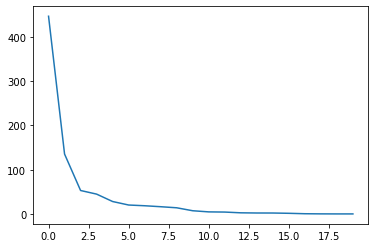

In [126]:
plt.plot(s[:20])

In [131]:
1068*977

1043436

In [130]:
p.S.shape

(1068, 977)

In [133]:
np.float(np.where(p.S>0.0)[0].shape) / 1068*977

<ipython-input-133-fa3270d42a3c>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(np.where(p.S>0.0)[0].shape) / 1068*977


TypeError: float() argument must be a string or a number, not 'tuple'

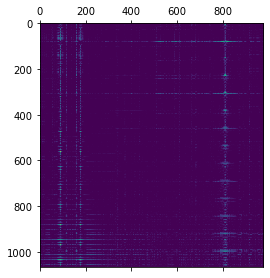

In [136]:
plt.matshow(np.abs(p.S), aspect="auto")

In [142]:
ss = np.sum(np.abs(p.S),  axis=0)

In [168]:
ssmax =np.max(ss)

In [144]:
ss_90=np.quantile(ss, 0.9)

In [166]:
ss10=np.where(ss>0.1* np.max(ss))[0]

In [167]:
len(ss10)

96

In [173]:
aaaa = np.where(ss>0.2* np.max(ss))[0]

In [175]:
len(aaaa) / 1000

0.041

In [171]:
ss2 = np.clip(ss, 0.2* ssmax,ssmax)

In [180]:
r = 0.2
ss = np.sum(np.abs(p.S),  axis=0)
ssmax = np.max(ss)
# plt.plot(np.clip(ss, r* ssmax,ssmax))
print(np.where(ss  >  r*ssmax)[0].shape)

(41,)


In [ ]:
for i

In [159]:
np.where( ss>0.1* np.max(ss)   fluxaa[:, aaaa].shape

(1068, 96)

In [163]:
np.sum(np.abs(fluxaa), 

array([[-0.48050364, -0.71498369, -0.88586536, ...,  0.        ,
         0.        , -0.54031616],
       [-0.62875286, -0.92126892, -1.12084027, ...,  0.        ,
         0.        , -0.63432637],
       [-0.77169389, -1.13406621, -1.37520948, ...,  0.        ,
         0.        , -0.69471888],
       ...,
       [-1.12826618, -1.70846649, -1.97506328, ...,  0.        ,
         0.        , -1.40260823],
       [-1.35390683, -1.87816941, -2.12933033, ...,  0.        ,
         0.        , -1.4401755 ],
       [-1.45610712, -1.91133675, -2.13577652, ...,  0.        ,
         0.        , -1.43676064]])

In [162]:
fluxaa[:, ~aaaa] =  0

In [ ]:
plt.plot

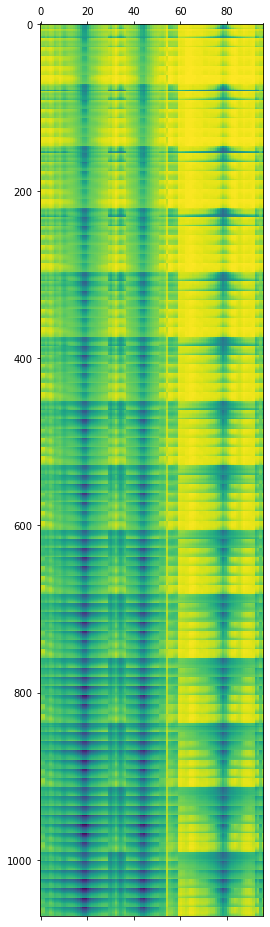

In [161]:
plt.matshow(fluxaa [:, aaaa],  aspect="auto")

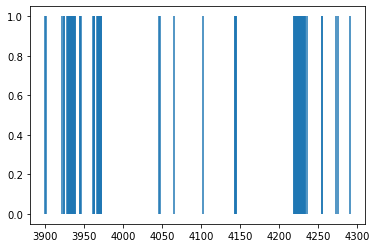

In [148]:
plt.vlines(waveaa[np.where(ss>ss_90)[0]], ymin=0,ymax=1)
plt.plot(waveaa, np.sum(np.abs(p.S), axis=0),c='r')

In [ ]:
ss>np.

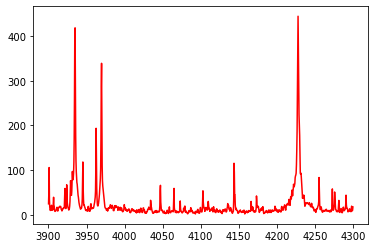

In [135]:
plt.plot(waveaa, np.sum(np.abs(p.S), axis=0),c='r')

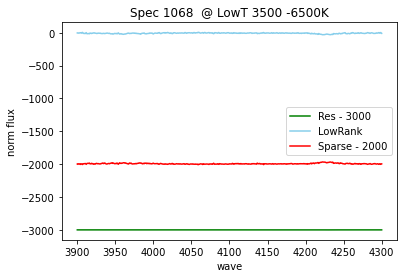

In [118]:
p.eval_pcp(waveaa)

In [106]:
s  = np.linalg.svd(fluxaaa,  compute_uv=0)

(0.0, 100.0)

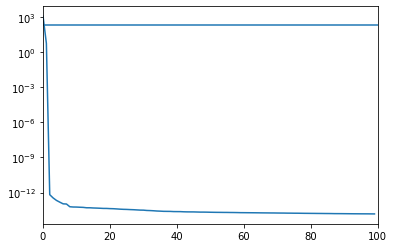

In [100]:
plt.plot(s[:100])
plt.hlines(p.gl, xmin=0, xmax=1000)
plt.yscale("log")
plt.xlim(0,100)

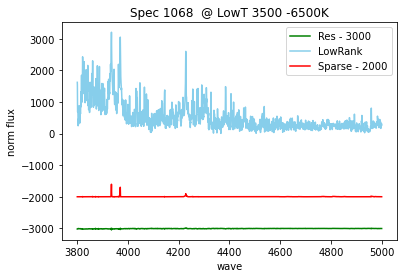

In [55]:
p.eval_pcp(waveaa)

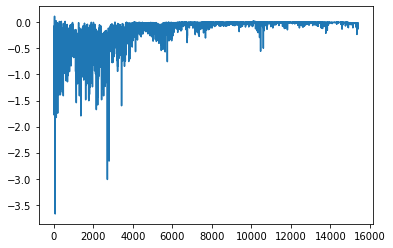

In [13]:
plt.plot(flux0[0])

### LOAD TRAINED DATA

In [8]:
DATA_PATH = "/home/swei20/LV/data/w8_95.h5"

In [9]:
with h5py.File(DATA_PATH, 'r') as f:
    flux = f['flux'][()]
    para = f['para'][()]
    wave = f['wave'][()]

In [10]:
SAVE_PATH = "/home/swei20/LV/data/w8_95_pca.h5"
with h5py.File(SAVE_PATH, 'r') as f:
    R = f['R'][()]
    S = f['S'][()]
    L = f['L'][()]

In [ ]:
eval_rpca(wave, R, S, L, flux, roff=3000, soff=2000)

In [11]:
def eval_rpca(wave, R, S, L, X, roff=3000, soff=2000):
    res = R + S + L - X
    plt.plot(wave, -res.sum(0)-roff, label=f"Res - {roff}", c='g')
    plt.plot(wave, -L.sum(0), label = "LowRank", c='skyblue')
    plt.plot(wave, -S.sum(0)-soff, label=f"Sparse - {soff}", c='r')
    plt.xlabel("wave")
    plt.ylabel("norm flux")
    plt.title(f"Spec {X.shape}  @ LowT 3500 -6500K")
    plt.legend()

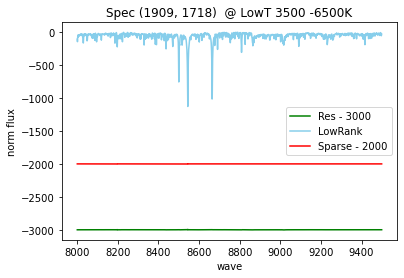

In [12]:
eval_rpca(wave, R, S, L, flux, roff=3000, soff=2000)

Robust PCA

In [51]:
def get_flux_in_Wrange(flux, wave, Ws):
    start = np.digitize(Ws[0], wave)
    end = np.digitize(Ws[1], wave)
    return flux[..., start:end], wave[start:end]

In [16]:
flux1, wave1 = get_flux_in_Wrange(flux0, wave, [3800, 13000])

In [95]:
flux2 = np.clip(-flux1, 0, None)

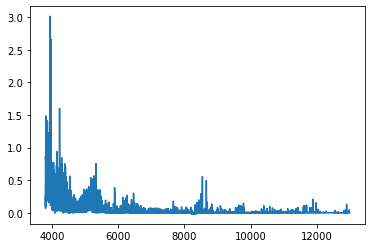

In [19]:
plt.plot(wave1, flux2[0])

In [20]:
m, n = flux2.shape

In [139]:
from lv.rpca_v1 import rpcaADMM

In [113]:
wave1

array([ 3800.3757,  3800.7556,  3801.1357, ..., 12996.7305, 12998.0312,
       12999.3311])

In [153]:
flux_test, wave_test = get_flux_in_Wrange(flux2, wave1, [4500, 9800])

In [ ]:
SAVE_PATH = "/home/swei20/LV/data/w45_98.h5"

In [ ]:
with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('flux', data = flux_3, shape=train_pc.shape)
    f.create_dataset('RBF_PATH', data = RBF_PATH)
    f.create_dataset('eigv', data = rbf.grid.eigv['flux'])
    f.create_dataset('eigs', data = rbf.grid.eigs['flux'])
    f.create_dataset('wave', data = rbf.wave)
    f.create_dataset('para', data = index)

In [218]:
flux_test00 = flux_test[id_test,:]

In [220]:
flux_test00.shape

(1936, 4105)

In [155]:
h = rpcaADMM(flux_test, parallel=0)

38432 4105


  0%|          | 0/100 [00:00<?, ?it/s]


iter	    r norm	   eps pri	    s norm	  eps dual	      loss


  1%|          | 1/100 [01:40<2:45:52, 100.53s/it]

   1	  909.3922	   13.4470	 1127.1486	   12.8851	 168794.49


 10%|█         | 10/100 [17:42<2:38:23, 105.59s/it]

  10	  644.8647	   32.0016	 1449.8649	   43.2563	6157486.89


 20%|██        | 20/100 [35:46<2:21:52, 106.40s/it]

  20	 1065.3002	   31.1385	 2281.2392	   39.2118	5097346.79


 30%|███       | 30/100 [54:05<2:06:10, 108.15s/it]

  30	  866.7198	   31.6257	 2178.5952	   39.0803	5225093.20


 40%|████      | 40/100 [1:12:10<1:47:34, 107.58s/it]

  40	 1046.0658	   29.9841	 1859.4397	   41.3952	5225881.72


 50%|█████     | 50/100 [1:29:47<1:26:43, 104.06s/it]

  50	  998.1770	   30.7322	 1222.1558	   39.2302	4915036.54


 60%|██████    | 60/100 [1:48:25<1:14:08, 111.21s/it]

  60	  986.2787	   31.3632	 2131.6012	   39.0172	5195744.54


 70%|███████   | 70/100 [2:06:05<51:31, 103.06s/it]  

  70	 1069.8794	   30.5555	 2169.3351	   40.5125	5266770.52


 80%|████████  | 80/100 [2:24:13<36:41, 110.06s/it]

  80	 1001.4897	   30.2592	 2328.5284	   39.9995	4939988.17


 90%|█████████ | 90/100 [2:42:23<18:03, 108.40s/it]

  90	 1359.0472	   30.1379	 2040.4084	   41.6295	5579852.60


100%|██████████| 100/100 [3:01:09<00:00, 108.70s/it]

 100	 1050.2166	   30.8375	 1571.8055	   41.6499	5737285.81


In [160]:
from lv.rpca_jkarnows import rpcaADMM

In [ ]:
h = rpcaADMM(flux_test, n_iter=10)


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	  726.6321	   13.1607	 1098.5192	   12.8851	 183509.39


In [204]:
h["addm_toc"]

98.17557144165039

In [171]:
from lv.rpca import RPCA

In [226]:
flux2.shape

(38432, 12299)

In [ ]:
flux_3, wave_3 = get_flux_in_Wrange(flux2, wave1, [4500, 9800])

In [ ]:
from lv.rpca import RPCA
pFull=RPCA(flux2)
pFull.pcp()

  0%|          | 0/100 [00:00<?, ?it/s]


iter	       res	     eps r	        dz	     eps U	      loss


In [ ]:
pFull

In [ ]:
eval_pcp(pFull, wave1, roff=800, soff=400)

In [221]:
X = flux_test00
p=RPCA(X)
p.pcp()

  0%|          | 0/100 [00:00<?, ?it/s]


iter	       res	     eps r	        dz	     eps U	      loss


  1%|          | 1/100 [00:15<25:05, 15.20s/it]

   1	  129.8678	    2.4751	  198.6813	    2.4264	   6190.52


 10%|█         | 10/100 [02:10<19:47, 13.20s/it]

  10	   31.5760	    3.1229	   23.2978	    2.6259	  26391.99


 20%|██        | 20/100 [04:42<19:46, 14.83s/it]

  20	   10.0627	    3.3769	    8.7963	    2.3103	  26727.24


 30%|███       | 30/100 [06:48<12:19, 10.57s/it]

  30	    4.6503	    3.3484	    3.0425	    2.2361	  25632.17


 31%|███       | 31/100 [07:20<16:19, 14.20s/it]

t: 440.27


In [223]:
def eval_pcp(self, wave, roff=3000, soff=2000):
    res = self.R + self.S + self.L - self.X
    plt.plot(wave, -res.sum(0)-roff, label=f"Res - {roff}", c='g')
    plt.plot(wave, -self.L.sum(0), label = "LowRank", c='skyblue')
    plt.plot(wave, -self.S.sum(0)-soff, label=f"Sparse - {soff}", c='r')
    plt.xlabel("wave")
    plt.ylabel("norm flux")
    plt.title(f"Spec {self.m}  @ LowT 3500 -6500K")
    plt.legend()

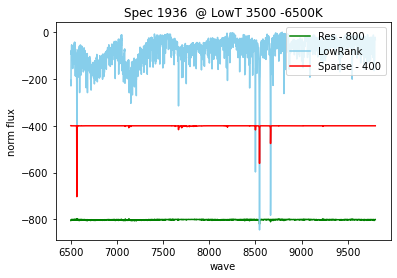

In [225]:
eval_pcp(p, wave_test, roff=800, soff=400)

In [211]:
def eval_pcp(p, wave):
    res = p.R + p.S + p.L - p.X
    plt.plot(wave, -res.sum(0)-3000, label="Res - 3k", c='g')
    plt.plot(wave, -p.L.sum(0), label = "LowRank", c='skyblue')
    plt.plot(wave, -p.S.sum(0)-2000, label="Sparse - 2k", c='r')
    plt.xlabel("wave")
    plt.ylabel("norm flux")
    plt.title(f"Spec {X.shape}  @ LowT 3500 -6500K")
    plt.legend()

In [214]:
p.S.shape

(1936, 1484)

In [194]:
para.iloc[idx]

F    13
T     0
L     5
C     3
O     3
Name: 35790, dtype: int64

In [ ]:
plt.plot

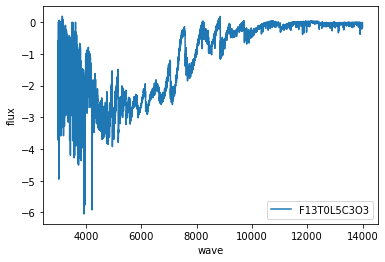

In [201]:
plt.plot(wave, flux0[idx], label = "F13T0L5C3O3")
plt.xlabel("wave")
plt.ylabel("flux")
plt.legend()

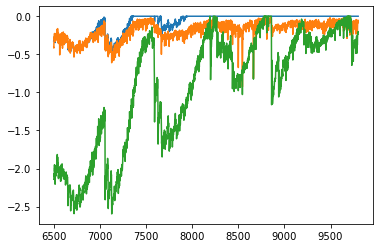

In [187]:
idx=35790
plt.plot(wave_test, -h["X2_admm"][idx], label='low Rank')
plt.plot(wave_test, -h["X3_admm"][idx])
plt.plot(wave_test, -flux_test[idx])

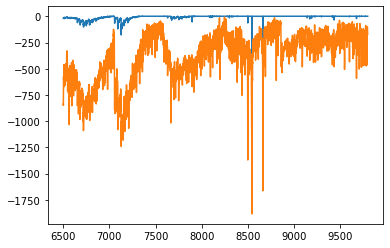

In [181]:
plt.plot(wave_test, 1-SS)
plt.plot(wave_test, 1-LL)

In [14]:
h

NameError: name 'h' is not defined

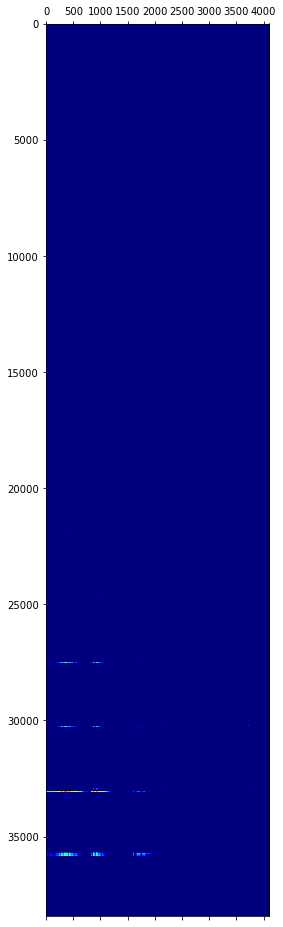

In [180]:
plt.matshow(h["X2_admm"], aspect="auto", cmap="jet")

In [ ]:
plt.plot(np.sum())

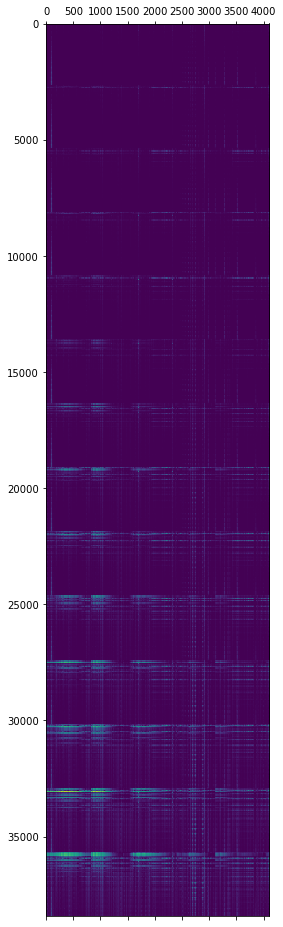

In [168]:
plt.matshow(flux_test, aspect="auto")

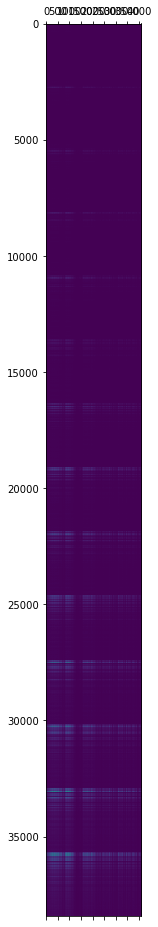

In [164]:
plt.matshow(h["X3_admm"])